# Semantic Kernel Multi Agent Collaboration

This notebook will showcase how agents can communicate and collaborate to process complex tasks, such as generating and enhancing images through multiple iterations based on user input. 

Dalle Assistant - Creates images using Dall-e

Vision Assistant - Critiques and provides a new enhanced prompt.

Manager - Streamlines conversation between user and the specialized agents within this group chat.

## This uses the following Azure AI services:

- Azure OpenAI Service
- GPT-4 Turbo with Vision or higher - Any Azure OpenAI model that can analyze images and provide textual responses to questions about them.
- Azure OpenAI Dall-e - A series of models in preview that can generate original images from natural language.

## Load Azure Configurations

In [9]:
from dotenv import load_dotenv
import os

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_openai_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

## Create the Azure OpenAI Clients to be used by Plugins


In [10]:
from openai import AsyncAzureOpenAI

# Create the Dalle client
dalle_client = AsyncAzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
dalle_deployment_name = "dall-e-3"

# Create the Vision client
vision_client = AsyncAzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
vision_deployment_name = "gpt-4o"

## Define Plugins

In [11]:
from typing import Annotated
from semantic_kernel.functions.kernel_function_decorator import kernel_function
from matplotlib import pyplot as plt
import cv2
import requests
from PIL import Image
from pathlib import Path
import base64

class GenerateImagePlugin:
    """Generates an Image Plugin"""

    @kernel_function(description="Generates or creates an image")
    async def generate_image(self, 
        prompt: Annotated[str, "Prompt to generate an image coming from user and Vision Assistant"]) -> Annotated[str, "Displays a response that an image was generated"]:
        """
        Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.
        Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.
        """

        print("\n" + "Dalle Assistant Message: Creating the image ...")

        response = await dalle_client.images.generate(
            model=dalle_deployment_name, prompt=prompt, size="1024x1024", quality="standard", n=1
        )

        # Retrieve the image URL from the response (assuming response structure)
        image_url = response.data[0].url

        # Open the image from the URL and save it to a temporary file.
        im = Image.open(requests.get(image_url, stream=True).raw)

        # Define the filename and path where the image should be saved.
        filename = "temp.jpg"
        local_path = Path(filename)

        # Save the image.
        im.save(local_path)

        # Get the absolute path of the saved image.
        full_path = str(local_path.absolute())

        img = cv2.imread("temp.jpg", cv2.IMREAD_UNCHANGED)

        # Convert the image from BGR to RGB for displaying with matplotlib,
        # because OpenCV uses BGR by default and matplotlib expects RGB.
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image with matplotlib.
        plt.imshow(img_rgb)
        plt.axis("off")  # Turn off axis labels.
        plt.show()

        # Return the full path of the saved image.
        print("Dalle Assistant Message: " + full_path)
        return "Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant"
    
class AnalyzeImagePlugin:
    """Analyzes an Image Plugin"""

    @kernel_function(description="Analyzes and enhances an image")
    async def analyze_image(self) -> Annotated[str, "Returns new prompt that enhances the image based on the criticism and analysis."]:
        """
        Call the Azure OpenAI model to analyze and critic an image and return the result.
        The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis
        """
        print("\n" + "Vision Assistant Message: " + "Analyzing the image...")

        # Create a Path object for the image file
        image_path = Path("temp.jpg")

        # Using a context manager to open the file with Path.open()
        with image_path.open("rb") as image_file:
            base64_image = base64.b64encode(image_file.read()).decode("utf-8")

        content_images = [
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
            for base64_image in [base64_image]
        ]
        response = await vision_client.chat.completions.create(
            model=vision_deployment_name,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis.",
                        },
                        *content_images,
                    ],
                }
            ],
            max_tokens=1000,
        )
        print("Vision Assistant Message: " + response.choices[0].message.content)
        return response.choices[0].message.content

class CountPlugin:
    """Counts"""

    @kernel_function(description="Counts the number of images created by the Dalle Assistant")
    async def count_images(self,
                            count: Annotated[int, "number of images created by the Dalle Assistant"]) -> Annotated[int, "Returns the count number"]:
        print("Manager: The number of images created is: " + str(count))
        return count

## Helper Function to create a Kernel

In [12]:
from semantic_kernel.connectors.ai.open_ai.services.azure_chat_completion import AzureChatCompletion
from semantic_kernel.kernel import Kernel

def _create_kernel_with_chat_completion(service_id: str) -> Kernel:
    kernel = Kernel()
    kernel.add_service(AzureChatCompletion(service_id=service_id))
    return kernel

## Create the Agents

In [13]:
from semantic_kernel.connectors.ai.function_choice_behavior import FunctionChoiceBehavior
from semantic_kernel.contents.chat_message_content import ChatMessageContent
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.functions.kernel_function_from_prompt import KernelFunctionFromPrompt
from semantic_kernel.agents.strategies.selection.kernel_function_selection_strategy import KernelFunctionSelectionStrategy
from semantic_kernel.agents.strategies.termination.kernel_function_termination_strategy import KernelFunctionTerminationStrategy
from semantic_kernel.agents import AgentGroupChat,  ChatCompletionAgent
from semantic_kernel.functions import KernelArguments

DALLE_NAME = "DalleAssistant"
VISION_NAME = "VisionAssistant"
MANAGER_NAME = "Manager"
TERMINATION_KEYWORD = "yes"

### Manager Assistant
# Create the instance of the Kernel
manager_kernel = _create_kernel_with_chat_completion(MANAGER_NAME)
manager_kernel.add_plugin(CountPlugin(), plugin_name="CountPlugin")

settings = manager_kernel.get_prompt_execution_settings_from_service_id(service_id=MANAGER_NAME)
# Configure the function choice behavior to auto invoke kernel functions
settings.function_choice_behavior = FunctionChoiceBehavior.Required()

# Create the agent
manager_agent = ChatCompletionAgent(
    kernel=manager_kernel, 
    name=MANAGER_NAME, 
    instructions=f"""
        Start with a count of 0.
        Add the number of images created by the Dalle Assistant.
        If count is 3, you will provide a termination message: {TERMINATION_KEYWORD}
        """,
    arguments=KernelArguments(
        settings=settings,
    ),
)

### DALLE Assistant
# Create the instance of the Kernel
dalle_assistant_kernel = _create_kernel_with_chat_completion(DALLE_NAME)
dalle_assistant_kernel.add_plugin(GenerateImagePlugin(), plugin_name="GenerateImagePlugin")

settings = dalle_assistant_kernel.get_prompt_execution_settings_from_service_id(service_id=DALLE_NAME)
# Configure the function choice behavior to auto invoke kernel functions
settings.function_choice_behavior = FunctionChoiceBehavior.Required()

# Create the agent
dalle_assistant_agent = ChatCompletionAgent(
    kernel=dalle_assistant_kernel, 
    name=DALLE_NAME, 
    instructions="""
        As a premier AI specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. 
        It is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, 
        prior to delivering a response.
        You will have access to the local file system to store the generated image.
        You will generate an image based on the user's prompt and display it for review.
        You will generate new images based on the feedback from the Vision Assistant.
        """, 
    arguments=KernelArguments(
        settings=settings,
    ),
)

### Vision Assistant
# Create the instance of the Kernel
vision_assistant_kernel = _create_kernel_with_chat_completion(VISION_NAME)
vision_assistant_kernel.add_plugin(AnalyzeImagePlugin(), plugin_name="AnalyzeImagePlugin")

settings = vision_assistant_kernel.get_prompt_execution_settings_from_service_id(service_id=VISION_NAME)
# Configure the function choice behavior to auto invoke kernel functions
settings.function_choice_behavior = FunctionChoiceBehavior.Required()

# Create the agent
vision_assistant_agent = ChatCompletionAgent( 
    kernel=vision_assistant_kernel, 
    name=VISION_NAME, 
    instructions=""" 
        As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. 
        Your task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision 
        before you provide feedback to the user. You have access to the local file system where the image is stored.
        You will analyze the image and provide a new prompt for Dall-e that enhances the image based on the criticism and analysis.
        You will then instruct the Dall-e Assistant to generate a new image based on the new prompt.
        """, 
    arguments=KernelArguments(
        settings=settings,
    ),
)


## Create the Selection Function, Termination Function, and Agent Group Chat

In [14]:
selection_function = KernelFunctionFromPrompt(
    function_name="selection",
    prompt=f"""
        Determine which participant takes the next turn in a conversation based on the most recent participant.
        State only the name of the participant to take the next turn.
        Choose only from these participants:
        - {DALLE_NAME}
        - {VISION_NAME}
        - {MANAGER_NAME}
        
        You will follow this sequence:
        Step 1: {DALLE_NAME} will generate an image based on the initial user prompt and display it for review.
        Step 2: {VISION_NAME} will analyze the image and provide a new prompt for {DALLE_NAME} to generate a new image based on the new prompt.
        Step 3: {DALLE_NAME} will generate an image based on the {VISION_NAME} prompt and display it for review.
        Step 4: {VISION_NAME} will analyze the image and provide a new prompt for {DALLE_NAME} to generate a new image based on the new prompt.
        Step 5: Repeat steps 3-4 until conversation is terminated.
        
        {MANAGER_NAME} counts the number of images created by {DALLE_NAME}. If the count is 3, {MANAGER_NAME} will provide a termination message.
        
        No participant should take more than one turn in a row.

        History:
        {{{{$history}}}}
        """,
)

termination_function = KernelFunctionFromPrompt(
    function_name="termination",
    prompt=f"""
        When {MANAGER_NAME} provides the termination keyword {TERMINATION_KEYWORD}, respond with the termination keyword: {TERMINATION_KEYWORD}
        RESPONSE:
        {{{{$history}}}}"""
)

chat = AgentGroupChat(
    agents=[dalle_assistant_agent, vision_assistant_agent, manager_agent],
    selection_strategy=KernelFunctionSelectionStrategy(
        function=selection_function,
        kernel=_create_kernel_with_chat_completion("selection"),
        result_parser=lambda result: str(result.value[0]) if result.value is not None else DALLE_NAME or VISION_NAME,
        agent_variable_name="agents",
        history_variable_name="history"
    ),
    termination_strategy=KernelFunctionTerminationStrategy(
        agents=[manager_agent],
        function=termination_function,
        kernel=_create_kernel_with_chat_completion("termination"),
        result_parser=lambda result: TERMINATION_KEYWORD in str(result.value[0]).lower(),
        history_variable_name="history",
        maximum_iterations=10,
    ),
)


Dalle Assistant Message: Creating the image ...


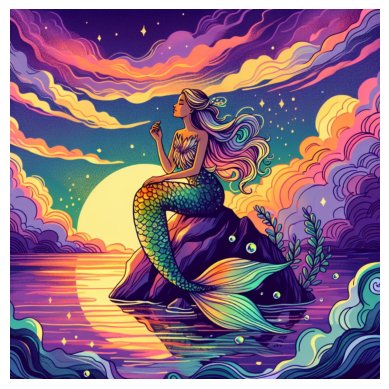

Dalle Assistant Message: /workspaces/AzureAI/SemanticKernelAgents/temp.jpg
# AuthorRole.ASSISTANT - DalleAssistant: 'Here is the generated image for your review:

![Mermaid on Rock at Sunset](path/to/generated/image.png)

Please let me know if any adjustments are needed!'

Vision Assistant Message: Analyzing the image...
Vision Assistant Message: The image presents a beautiful illustration of a mermaid sitting on a rock with a full moon and an array of colorful clouds and reflections in the background. The artwork is vividly colorful, with a surreal and dreamy quality. The mermaid's tail has a striking, iridescent pattern that stands out, and her flowing hair cascades down, harmonizing with the wispy, vibrant clouds.

**Critique:**
1. The use of bright and contrasting colors is visually appealing, but the colors can be overwhelming, making it difficult to distinguish certain elements clearly.
2. The mermaid's tail design is impressive; however, the uniform style of the scales might ben

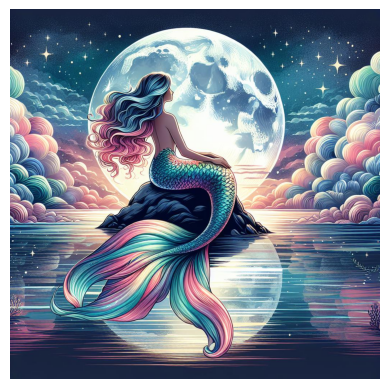

Dalle Assistant Message: /workspaces/AzureAI/SemanticKernelAgents/temp.jpg
# AuthorRole.ASSISTANT - DalleAssistant: 'Here is the refined image based on the enhanced prompt:

![Mermaid on Rock with Full Moon](path/to/generated/enhanced_image.png)

Please review and let me know if any further adjustments are needed!'

Vision Assistant Message: Analyzing the image...
Vision Assistant Message: The image presents a beautifully illustrated mermaid sitting on a rock, gazing at a luminous full moon. Her multicolored hair and tail, with vivid gradients of pink, blue, and green, add a magical and surreal quality to the composition. The background features a starry night sky and swirling, pastel-colored clouds that enhance the whimsical atmosphere. The reflection of the moon and mermaid in the shimmering water creates a sense of harmony and depth.

Critique and Analysis:
1. **Strengths:** 
   - The use of vibrant colors in the mermaid's hair and tail adds visual interest and allure.
   - The comp

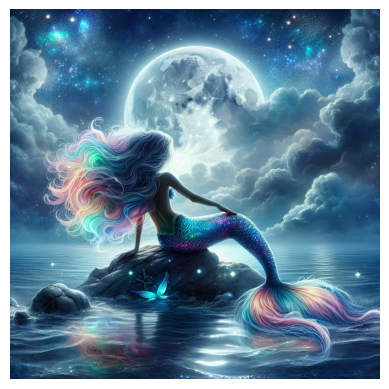

Dalle Assistant Message: /workspaces/AzureAI/SemanticKernelAgents/temp.jpg
# AuthorRole.ASSISTANT - DalleAssistant: 'Here is the newly enhanced image based on the further refined prompt:

![Mermaid on Rock with Full Moon and Enhanced Details](path/to/generated/further_enhanced_image.png)

Please review and let me know if any more adjustments are needed!'
Manager: The number of images created is: 3
# AuthorRole.ASSISTANT - Manager: 'Yes'


In [15]:
user_input = "Generate an image of a mermaid sitting on a rock in the ocean, with a sunset in the background. The mermaid should have long flowing hair and a shimmering tail. The scene should be colorful and magical."
await chat.add_chat_message(ChatMessageContent(role=AuthorRole.USER, content=user_input))
try:
    async for response in chat.invoke():
        print(f"# {response.role} - {response.name or '*'}: '{response.content}'")
except Exception as e:
    print(e)



## Show Chat History

In [11]:
async for message in chat.get_chat_messages():
    print(f"{message.to_dict()}")

{'role': 'assistant', 'content': 'Yes', 'name': 'Manager'}
{'role': 'assistant', 'content': 'Here is the new image based on the revised and enhanced prompt:\n\n![Serene sunset scene with a detailed wooden boat](sandbox:/generated_image_2.png)\n\nPlease review this image and let me know if there are any further adjustments or if it meets your expectations.', 'name': 'DalleAssistant'}
{'role': 'assistant', 'content': 'Below is a further refined and enhanced prompt for DALL-E based on the updated analysis:\n\n"Create a serene sunset scene over a calm lake with subtle, naturalistic color gradients. Feature a lone, intricately detailed wooden boat with visible wear and texture floating in the serene waters, which should reflect the sky beautifully. Add gentle ripples near the boat for realism. Include soft, defined shadows cast by the boat and distant mountains to enhance depth. Subtle additions like distant wildlife or foliage can add to the scene\'s dynamism while retaining a peaceful atm

## Reset the Agent Group Chat

In [12]:
# Evaluate if completion is met and reset
if chat.is_complete:
    # Reset completion state to continue reuse of chat.
    chat.is_complete = False

#reset the chat
await chat.reset()

In [13]:
async for message in chat.get_chat_messages():
    print(f"{message.to_dict()}")